## Imports


In [1]:
%%capture
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import itertools
from sklearn.utils import shuffle
%run "./utils.ipynb"
%run "./Data preprocessing.ipynb"

## Load Numpy Array

In [2]:
X.shape

(17615, 100, 100)

In [3]:
np.unique(y)

array([0, 1, 2, 3, 4])

### Resize array

In [4]:
X, y = shuffle(X, y, random_state=0)  

In [5]:
X = np.stack((X,)*3, axis=-1)
print(X.shape)

(17615, 100, 100, 3)


### Train

In [6]:
from tensorflow.keras.applications import VGG16,VGG19,NASNetMobile,DenseNet169
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam

In [7]:
X = tf.keras.applications.densenet.preprocess_input(
    X, data_format=None
)

In [8]:
from sklearn.model_selection import train_test_split
# split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state = 101, stratify=y)

In [9]:
model = Sequential()

conv_base = DenseNet169(input_shape=(100,100,3), include_top=False, pooling='max',weights='imagenet')
# conv_base.trainable = False
model.add(conv_base)
model.add(Dense(5, activation='softmax'))

train_layers = [layer for layer in conv_base.layers[::-1][:2]]
# print(train_layers)
# print(len(train_layers), "train len")

for layer in conv_base.layers:
  if layer in train_layers:
    layer.trainable = True

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 1664)              12642880  
_________________________________________________________________
dense (Dense)                (None, 5)                 8325      
Total params: 12,651,205
Trainable params: 12,492,805
Non-trainable params: 158,400
_________________________________________________________________


In [11]:
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=20, callbacks=cbs,verbose=1)

Train on 13211 samples, validate on 4404 samples
Epoch 1/20
13211/13211 [==============================] - 147s 11ms/sample - loss: 0.4551 - accuracy: 0.8364 - val_loss: 0.2686 - val_accuracy: 0.9010
Epoch 2/20
13211/13211 [==============================] - 115s 9ms/sample - loss: 0.1366 - accuracy: 0.9503 - val_loss: 0.1570 - val_accuracy: 0.9450
Epoch 3/20
13211/13211 [==============================] - 115s 9ms/sample - loss: 0.0661 - accuracy: 0.9782 - val_loss: 0.1293 - val_accuracy: 0.9612
Epoch 4/20
13211/13211 [==============================] - 115s 9ms/sample - loss: 0.0554 - accuracy: 0.9812 - val_loss: 0.1817 - val_accuracy: 0.9521
Epoch 5/20
13211/13211 [==============================] - 115s 9ms/sample - loss: 0.0227 - accuracy: 0.9926 - val_loss: 0.0965 - val_accuracy: 0.9748

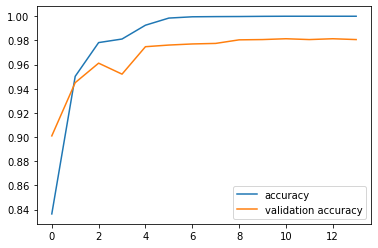

In [12]:
accuracy_graph(history)

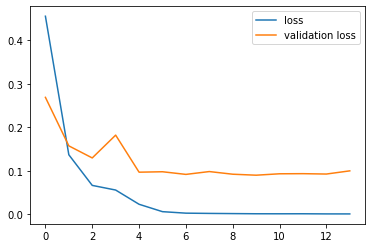

In [13]:
loss_graph(history)

In [14]:
predictions = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, predictions)

Confusion matrix, without normalization
[[892   1   1   5   5]
 [  2 827  46   0   0]
 [  0   9 866   0   0]
 [  7   0   0 866   2]
 [  7   0   0   0 868]]


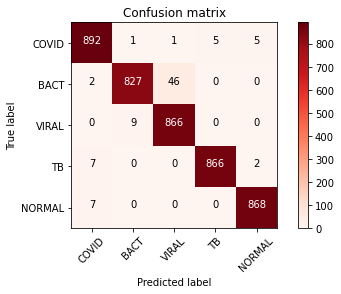

In [15]:
plot_confusion_matrix(cm, ["COVID" ,"BACT", "VIRAL", "TB", "NORMAL"])

In [17]:
print(classification_report(y_test, predictions));

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       904
           1       0.99      0.95      0.97       875
           2       0.95      0.99      0.97       875
           3       0.99      0.99      0.99       875
           4       0.99      0.99      0.99       875

    accuracy                           0.98      4404
   macro avg       0.98      0.98      0.98      4404
weighted avg       0.98      0.98      0.98      4404



In [18]:
model.save('DenseNet169.h5')